In [12]:
import numpy as np
import pandas as pd

from ebhconformal import utils
from ebhconformal.utils.multiple_testing import pBH, eBH, eBH_infty, evaluate
from ebhconformal.utils.p2e import p2e
from ebhconformal.utils.rej_functions import ebh_rej_function, ebh_infty_rej_function, ebh_union_rej_function
from ebhconformal.utils.ci_sequence import get_alpha_cs, get_rho, hedged_cs, asy_cs, asy_log_cs 
from ebhconformal.utils.generating_data import *

import matplotlib.pyplot as plt
import os

from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import scipy.linalg
from sklearn import svm, ensemble, neighbors

from sklearn.svm import OneClassSVM

In [13]:
import numpy as np
from scipy.linalg import toeplitz

def gen_data(Wset, n, a, dim = 50): 
    Wi = Wset[np.random.choice(range(dim), n),:]
    Vi = np.random.normal(size=n*dim).reshape((n,dim))
    Xi = np.sqrt(a) * Vi + Wi
    return(Xi)
    
def gen_weight(Xi, theta):
    linx = Xi @ theta   
    wx = np.exp(linx) / (1+ np.exp(linx))    
    return(wx)
    
def gen_data_weighted(Wset, n, a, theta, dim = 50):
    Wi = Wset[np.random.choice(range(dim), n),:]
    Vi = np.random.normal(size=n*dim).reshape((n,dim))
    Xi = np.sqrt(a) * Vi + Wi
    wx = gen_weight(Xi, theta)
    sel = np.random.binomial(n=1, p=wx[:,0])
    X_sel = Xi[sel==1,:]
    X = X_sel
    
    while X.shape[0] < n:
        Wi = Wset[np.random.choice(range(dim), n),:]
        Vi = np.random.normal(size=n*dim).reshape((n,dim))
        Xi = np.sqrt(a) * Vi + Wi
        wx = gen_weight(Xi, theta)
        sel = np.random.binomial(n=1, p=wx[:,0])
        X_sel = Xi[sel==1,:]
        X = np.concatenate((X, X_sel))
    
    X = X[range(n),:]
    
    return(X)

#The entirety of KFC procedure gets killed by the alpha-fdr here - ASK JUNU
# OR set up separate thresholds

def eBH(e, alpha, return_set=True):
    '''
    Runs the eBH procedure to control FDR at given level alpha.
        
        Parameters:
            e : The e-values on which to run the procedure.
            alpha : The level at which to control FDR.
            
        Returns:
            rej: The rejection set; the selected indices that have rejected nulls.
        
    '''
    m = len(e)
    e_sort = np.sort(e)[::-1] # descending order
    khat = 0
    for k in range(m,0,-1):
        if e_sort[k-1] >= m/(alpha*k):
            khat = k
            break
    if khat == 0:
        if return_set:
            return np.array([])
        else:
            return np.zeros(m)
    else:
        if return_set:
            return np.nonzero(np.array(e) >= m/(alpha*khat))[0]
        else:
            return (np.array(e) >= m/(alpha*khat))

def subroutine(classifier, Xref, Xtest, blocks, negate_scores=True):
    m = Xtest.shape[0]
    n = Xref.shape[0]
    
    scores = np.zeros(shape=(m,n+m))
    if len(blocks)==1:
        # 1-FC: this is just the default full conformal, without leave-one-out training
        Xaugmented = np.vstack((Xref, Xtest))
        
        # train on the ref+test dataset
        classifier.fit(Xaugmented)
        
        # score samples
        score_samples = classifier.score_samples(Xaugmented).flatten()
    
        # since we only have 1 block, only one distinct row in the conformity score matrix
        scores = np.tile(score_samples, (m, 1))
        
        return -1 * scores
    
    for block_idx, block in enumerate(blocks):
        Xaugmented = np.vstack((Xref, Xtest[block]))

        # train on the augmented dataset
        classifier.fit(Xaugmented)

        # score the samples
        # D_ref first
        score_samples = classifier.score_samples(Xaugmented).flatten()
        scores[block,:n] = score_samples[:n]
        
        # D_test[block] next
        test_scores = np.zeros(m)
        test_scores[block] = score_samples[n:]
        
        # D_test[-block] last
        all_but_block = np.setdiff1d(range(m), block)
        test_scores[all_but_block] = classifier.score_samples(Xtest[all_but_block]).flatten()
        scores[block,n:] = test_scores
        
        
    #print(-1 * scores)
    return -1 * scores
        
def compute_power(rejections, H_1):
    """
    Returns a scalar corresponding to the power of the procedure
    """
    true_d = len(set(rejections) & set(H_1))
    return true_d/max(1, len(H_1))

def compute_fdp(rejections, H_1):
    """
    Returns a scalar corresponding to the FDP (False Discovery Proportion) of the procedure
    """
    R = len(rejections)
    true_d = len(set(rejections) & set(H_1))
    return true_d/max(R,1)

def quantile_func(score, scores):
    """
    Returns an empirical quantile of the element in an array
    """
    scores = np.array(scores)
    return np.mean(scores <= score)

def quantile_inverse(q, scores):
    """
    Returns a the lowest value in an array, which exceeds certain quantile
    """
    scores = np.array(scores)
    return np.percentile(scores, q * 100)

def logit(x):
    
    if x == 1:
        x -= 0.001
    return np.log(x / (1 - x))

def logistic(z):
    return 1 / (1 + np.exp(-z))

def e_function_static(alpha, score_matrix, cal_weights, test_weights): 
    """
    Returns the e-values
    """
    m, total = score_matrix.shape
    n = total - m

    sum_cal_weights = sum(cal_weights)
    # denom = test_weights + sum_cal_weights    # this is a m-dim array 

    T_array = np.ones(m) * np.inf
    e = np.zeros(m)

    range_list = list(range(m)) 

    for j in range(m):
        # unpack the jth set of leave-one-out scores
        cal_scores = score_matrix[j,:n]
        test_scores = score_matrix[j,n:]

        sum_weights_j = (sum_cal_weights+test_weights[j])

        combined_weights = np.concatenate((test_weights, cal_weights))
        combined_scores = np.concatenate((test_scores, cal_scores))
        combined_memberships = np.concatenate((np.ones(m), np.zeros(n)))

        inds = np.argsort(-1 * combined_scores)

        ordered_weights = combined_weights[inds]  
        cal_bools = (combined_memberships[inds] == 0)    # determine membership of the ordered scores
        # cal_weights_ordered = ordered_weights * (combined_memberships[inds] == 0)    # only keep the ordered weights belonging to the reference set

        test_seq = np.cumsum(combined_memberships[inds] == 1)
        cal_seq = np.cumsum( cal_bools * ordered_weights )    # this ends up being a np.cumsum over weighted indicators
        test_seq[test_seq == 0] = 1

        hat_fdrs = (cal_seq + test_weights[j]) / test_seq * m / sum_weights_j

        # find the j-specific threshold
        if np.any(hat_fdrs <= alpha):
            T_j = combined_scores[inds[np.where(hat_fdrs <= alpha)[0].max()]]
            # if T == 0:
            #     T = np.min([W > 0])
        else:
            T_j = max(combined_scores) + 1

        T_array[j] = T_j

        denom_j = test_weights[j] + sum( (cal_scores >= T_j) * cal_weights )
        e_j = sum_weights_j * (test_scores[j] >= T_j) / denom_j
        e[j] = e_j 
    return e

def base_e_function(alpha, scores, n):
    """
    This function optimizes computation of the generalized function. 
    """
    train = scores[:n]
    test = scores[n:]
    m = len(scores) - n 
    
    # Get the sorted unique candidate thresholds from V.
    candidate_t = np.sort(np.unique(scores))
    
    T = None
    # Iterate over candidate thresholds (from smallest to largest) to find the infimum T.
    for t in candidate_t:
        count_train = np.sum(train >= t)
        count_test = np.sum(test >= t)
        # Use max(1, count_alt) to avoid division by zero.
        ratio = (m / (n + 1)) * (1 + count_train) / max(1, count_test)
        if ratio <= alpha:
            T = t
            break

    # If no threshold satisfies the condition, set T to infinity.
    if T is None:
        T = np.inf

    # Compute the denominator for the e-value formula.
    count_at_T = np.sum(train >= T)
    # Compute e-values for each alternative.
    e_values = (n + 1) * (test >= T).astype(float) / (1 + count_at_T)
    
    return e_values

In [16]:
def find_extremal_set(rej_sets, maximum=True):
    """
    Outputs the set of the largest size from the given collection
    """
    
    if maximum:
        idx = max(range(len(rej_sets)), key=lambda i: len(rej_sets[i]))
    else:
        idx = min(range(len(rej_sets)), key=lambda i: len(rej_sets[i]))
    return idx

def find_most_deviating(rej_sets):
    if not rej_sets:
        return None 
    rej_sets = [set(s) for s in rej_sets]
    intersection = set.intersection(*rej_sets)
    
    deviations = [len(rej_set.symmetric_difference(intersection))
        for rej_set in rej_sets]

    return deviations.index(np.median(deviations))
    

def rej_classifier(classifier, Xtrain, Xtest, block, alpha_fdr, adj = True):
    """
    Outputs the rejection set for a single classifier
    """
    
    if adj:
        adjustment= 1/(1+alpha_fdr)
    else:
        adjustment = 1
    
    m = Xtest.shape[0]    
    n = Xtrain.shape[0]

    Xtrain = np.vstack((Xtrain, Xtest[block]))
    all_but_block = np.setdiff1d(range(m), block)
    Xtest = Xtest[all_but_block]
    
    #We make an augmented matrix of all values
    Xaugmented = np.vstack((Xtrain, Xtest))
    classifier.fit(Xtrain)

    # score only test samples
    score_samples = -1*classifier.score_samples(Xaugmented).flatten()
    e_values = base_e_function(adjustment*alpha_fdr, score_samples, n)
    e_rej = eBH(e_values, alpha_fdr)
    return e_rej

def subroutine_familywise(classifier_family, Xref, Xtest, blocks, alpha_fdr):
    """
    Outputs the rejection set for a family-wise procedure
    """
    m = Xtest.shape[0]
    n = Xref.shape[0]
    adjustment= 1/(1+alpha_fdr)
    scores = np.zeros(shape=(m,n+m))
    e_values = []

    for block_idx, block in enumerate(blocks):
        rej_sets = []
        for classifier in classifier_family:
            S_j = rej_classifier(classifier, Xref, Xtest, block, alpha_fdr)
            rej_sets.append(S_j)
            
        #We apply the scoring function
        idx = find_extremal_set(rej_sets, maximum = True)
        
        #Here we find the classifier which has the best score:
        best_classifier = classifier_family[idx]

        Xaugmented = np.vstack((Xref, Xtest[block]))
        best_classifier.fit(Xaugmented)

        # score the samples
        score_samples = best_classifier.score_samples(Xaugmented).flatten()
        scores[block,:n] = score_samples[:n]
        
        # D_test[block] next
        test_scores = np.zeros(m)
        test_scores[block] = score_samples[n:]
        
        # D_test[-block] last
        all_but_block = np.setdiff1d(range(m), block)
        test_scores[all_but_block] = best_classifier.score_samples(Xtest[all_but_block]).flatten()
        scores[block,n:] = test_scores

    e_values_family = e_function_static(0.5*alpha_fdr, (-1)*scores, np.ones(n), np.ones(m)) #This constant is not optimal
    e_rej = eBH(e_values_family, alpha_fdr)
    return e_rej


In [27]:
n = 1000
m = 200
K_blocks = 20
alpha_fdr = 0.05
prop_outliers = 0.2
adjustment = 1/(1+alpha_fdr)
n_exp = 20

#We set up important lists
settings = {'amp': 4.0, 'amps': [2.0, 2.5, 3.0, 3.5, 4.0], 'prop_outliers': 0.2, 'props_outliers': [0.1, 0.2, 0.3, 0.4] }
results_power = {'KFC':[], 'Family': []}
results_fdr = {'KFC':[], 'Family': []}

#Baseline model
KFC_classifier = OneClassSVM(nu=0.8, kernel='rbf', gamma='scale')  # initialize base model

#We construct the family of models
model_parameters = [0.1,0.3,0.5, 0.7, 0.9]
model_family = []

for nu in model_parameters:
    model_family.append(OneClassSVM(nu=nu, kernel='rbf', gamma='scale'))

In [28]:
amp=3

Wset = np.random.uniform(size=(50,50)) * 6 - 3
n_outliers = int(np.ceil(m * prop_outliers))
blocks = np.array_split(np.arange(m), K_blocks) 

# generate null and alternative hypotheses
Xref = gen_data(Wset, n, 1)
perm = np.random.permutation(m) 
nonzero = np.sort(perm[:n_outliers])
nulls = np.sort(perm[n_outliers:])

# don't generate test dataset under covariate shift
Xtest0 = gen_data(Wset, m-n_outliers, 1)    # inliers 
Xtest1 = gen_data(Wset, n_outliers, amp)    # outliers

# weights are just ones vector
test_weights = np.ones(m)
cal_weights = np.ones(n)

Xtest = np.zeros((m, Xtest0.shape[1]))
Xtest[nonzero,] = Xtest1
Xtest[nulls,] = Xtest0

family_e_rej = subroutine_familywise(model_family, Xref, Xtest, blocks, alpha_fdr)

baseline_score_matrix = subroutine(KFC_classifier, Xref, Xtest, blocks) 
e_values_KFC = e_function_static(0.5*alpha_fdr, baseline_score_matrix, cal_weights, test_weights)
e_rej = eBH(e_values_KFC, alpha_fdr)



print(nonzero)
print(compute_fdp(family_e_rej, nulls), compute_power(family_e_rej, nonzero))
print(compute_fdp(e_rej , nulls), compute_power(e_rej , nonzero))


[  0   5   8  16  21  25  29  36  37  40  43  47  49  50  53  54  59  73
  75  87  92  93  94  98 111 142 148 152 153 156 161 164 165 166 171 172
 174 184 185 196]
0.037037037037037035 0.65
0.037037037037037035 0.65


In [29]:
#We set the setting here
setting = 'FDP'
adjustment = 0.5
if setting == 'FDP':
    amp = settings['amp']
    for prop_outliers in settings['props_outliers']:
        fdp_KFC = []
        fdp_family = []
        for exp in range(n_exp):
            np.random.seed(exp)
            #We repeat the same structure of the experiement
            Wset = np.random.uniform(size=(50,50)) * 6 - 3
            n_outliers = int(np.ceil(m * prop_outliers))
            blocks = np.array_split(np.arange(m), K_blocks) 
            
            # generate null and alternative hypotheses
            Xref = gen_data(Wset, n, 1)
            perm = np.random.permutation(m) 
            nonzero = np.sort(perm[:n_outliers])
            nulls = np.sort(perm[n_outliers:])
            
            # don't generate test dataset under covariate shift
            Xtest0 = gen_data(Wset, m-n_outliers, 1)    # inliers 
            Xtest1 = gen_data(Wset, n_outliers, amp)    # outliers
            
            # weights are just ones vector
            test_weights = np.ones(m)
            cal_weights = np.ones(n)
            
            Xtest = np.zeros((m, Xtest0.shape[1]))
            Xtest[nonzero,] = Xtest1
            Xtest[nulls,] = Xtest0
            
            e_rej_family =subroutine_familywise(model_family, Xref, Xtest, blocks, alpha_fdr)
            baseline_score_matrix = subroutine(KFC_classifier, Xref, Xtest, blocks) 
            
            e_values_KFC = e_function_static(adjustment*alpha_fdr, baseline_score_matrix, cal_weights, test_weights)
            e_rej = eBH(e_values_KFC, alpha_fdr)

            fdp_KFC.append(compute_fdp(e_rej, nulls))
            fdp_family.append(compute_fdp(e_rej_family, nulls))
            print(f'{exp}/{n_exp} Done')
        print(f'FDR KFC: {np.mean(fdp_KFC)}, FDR Family: {np.mean(fdp_family)}')
        results_fdr['KFC'].append(fdp_KFC)
        results_fdr['Family'].append(fdp_family)
    

0/20 Done
1/20 Done
2/20 Done
3/20 Done
4/20 Done
5/20 Done
6/20 Done
7/20 Done
8/20 Done
9/20 Done
10/20 Done
11/20 Done
12/20 Done
13/20 Done
14/20 Done
15/20 Done
16/20 Done
17/20 Done
18/20 Done
19/20 Done
FDR KFC: 0.018113912231559292, FDR Family: 0.02212762297901617
0/20 Done
1/20 Done
2/20 Done
3/20 Done
4/20 Done
5/20 Done
6/20 Done
7/20 Done
8/20 Done
9/20 Done
10/20 Done
11/20 Done
12/20 Done
13/20 Done
14/20 Done
15/20 Done
16/20 Done
17/20 Done
18/20 Done
19/20 Done
FDR KFC: 0.021006328867637186, FDR Family: 0.020744330622426598
0/20 Done
1/20 Done
2/20 Done
3/20 Done
4/20 Done
5/20 Done
6/20 Done
7/20 Done
8/20 Done
9/20 Done
10/20 Done
11/20 Done
12/20 Done
13/20 Done
14/20 Done
15/20 Done
16/20 Done
17/20 Done
18/20 Done
19/20 Done
FDR KFC: 0.014474717038691628, FDR Family: 0.015966759831266584
0/20 Done
1/20 Done
2/20 Done
3/20 Done
4/20 Done
5/20 Done
6/20 Done
7/20 Done
8/20 Done
9/20 Done
10/20 Done
11/20 Done
12/20 Done
13/20 Done
14/20 Done
15/20 Done
16/20 Done
17

In [30]:
#We set the setting here
setting = 'Power'

if setting == 'Power':
    prop_outliers = settings['prop_outliers']
    for amp in settings['amps']:
        power_KFC = []
        power_family = []
        for exp in range(n_exp):
            np.random.seed(exp)
            #We repeat the same structure of the experiement
            Wset = np.random.uniform(size=(50,50)) * 6 - 3
            n_outliers = int(np.ceil(m * prop_outliers))
            blocks = np.array_split(np.arange(m), K_blocks) 
            
            # generate null and alternative hypotheses
            Xref = gen_data(Wset, n, 1)
            perm = np.random.permutation(m) 
            nonzero = np.sort(perm[:n_outliers])
            nulls = np.sort(perm[n_outliers:])
            
            # don't generate test dataset under covariate shift
            Xtest0 = gen_data(Wset, m-n_outliers, 1)    # inliers 
            Xtest1 = gen_data(Wset, n_outliers, amp)    # outliers
            
            # weights are just ones vector
            test_weights = np.ones(m)
            cal_weights = np.ones(n)
            
            Xtest = np.zeros((m, Xtest0.shape[1]))
            Xtest[nonzero,] = Xtest1
            Xtest[nulls,] = Xtest0
            
            e_rej_family =subroutine_familywise(model_family, Xref, Xtest, blocks, alpha_fdr)
            
            baseline_score_matrix = subroutine(KFC_classifier, Xref, Xtest, blocks) 
            e_values_KFC = e_function_static(adjustment*alpha_fdr, baseline_score_matrix, cal_weights, test_weights)
            e_rej = eBH(e_values_KFC, alpha_fdr)

            power_KFC.append(compute_power(e_rej, nonzero))
            power_family.append(compute_power(e_rej_family, nonzero))
            print(f'{exp}/{n_exp} Done')
        print(f'Finished {amp}, Power KFC: {np.mean(power_KFC)}, Power Family: {np.mean(power_family)}')
        results_power['KFC'].append(power_KFC)
        results_power['Family'].append(power_family)

0/20 Done
1/20 Done
2/20 Done
3/20 Done
4/20 Done
5/20 Done
6/20 Done
7/20 Done
8/20 Done
9/20 Done
10/20 Done
11/20 Done
12/20 Done
13/20 Done
14/20 Done
15/20 Done
16/20 Done
17/20 Done
18/20 Done
19/20 Done
Finished 2.0, Power KFC: 0.0225, Power Family: 0.05
0/20 Done
1/20 Done
2/20 Done
3/20 Done
4/20 Done
5/20 Done
6/20 Done
7/20 Done
8/20 Done
9/20 Done
10/20 Done
11/20 Done
12/20 Done
13/20 Done
14/20 Done
15/20 Done
16/20 Done
17/20 Done
18/20 Done
19/20 Done
Finished 2.5, Power KFC: 0.15375, Power Family: 0.30624999999999997
0/20 Done
1/20 Done
2/20 Done
3/20 Done
4/20 Done
5/20 Done
6/20 Done
7/20 Done
8/20 Done
9/20 Done
10/20 Done
11/20 Done
12/20 Done
13/20 Done
14/20 Done
15/20 Done
16/20 Done
17/20 Done
18/20 Done
19/20 Done
Finished 3.0, Power KFC: 0.4925, Power Family: 0.57875
0/20 Done
1/20 Done
2/20 Done
3/20 Done
4/20 Done
5/20 Done
6/20 Done
7/20 Done
8/20 Done
9/20 Done
10/20 Done
11/20 Done
12/20 Done
13/20 Done
14/20 Done
15/20 Done
16/20 Done
17/20 Done
18/20 D

In [31]:
FDR_KFC = []
err_KFC = []

FDR_family = []
err_family = []

power_KFC = []
err_power_KFC = []

power_family = []
err_power_family = []

#Main plots
for idx, pi in enumerate(settings['props_outliers']):
    FDR_KFC.append(np.mean(results_fdr['KFC'][idx]))
    FDR_family.append(np.mean(results_fdr['Family'][idx]))
    err_KFC.append(np.std(results_fdr['KFC'][idx]))
    err_family.append(np.std(results_fdr['Family'][idx]))
for idx, amp in enumerate(settings['amps']):
    err_power_KFC.append(np.std(results_power['KFC'][idx]))
    err_power_family.append(np.std(results_power['Family'][idx]))
    power_KFC.append(np.mean(results_power['KFC'][idx]))
    power_family.append(np.mean(results_power['Family'][idx]))

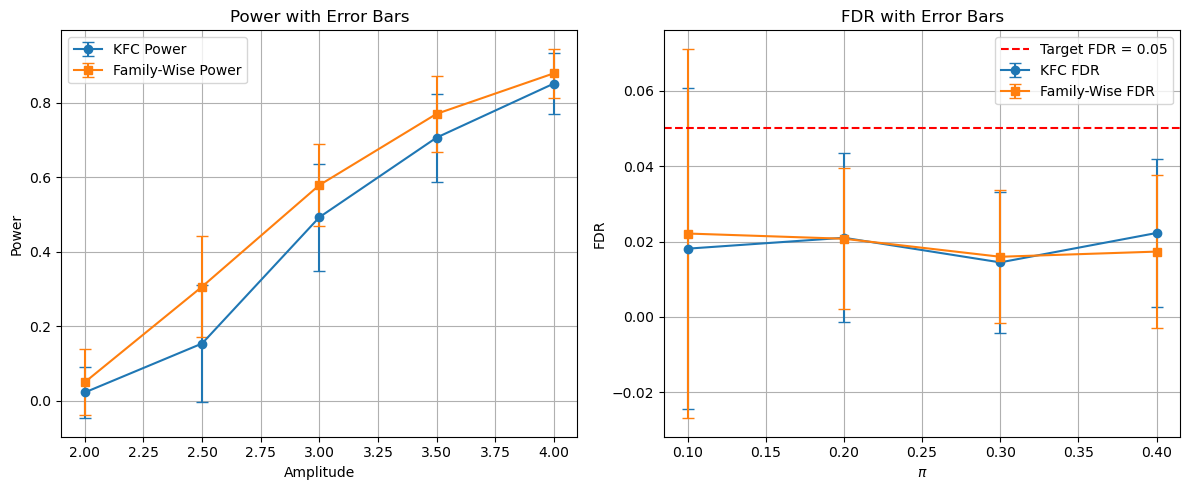

In [32]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot power with error bars
axes[0].errorbar(settings['amps'], power_KFC, yerr=err_power_KFC, fmt='-o', capsize=4, label='KFC Power')
axes[0].errorbar(settings['amps'], power_family, yerr=err_power_family, fmt='-s', capsize=4, label='Family-Wise Power')
axes[0].set_xlabel(r'Amplitude')
axes[0].set_ylabel('Power')
axes[0].set_title('Power with Error Bars')
axes[0].legend()
axes[0].grid(True)

# Plot FDR with error bars
axes[1].errorbar(settings['props_outliers'], FDR_KFC, yerr=err_KFC, capsize=4, fmt='-o', label='KFC FDR')
axes[1].errorbar(settings['props_outliers'], FDR_family, yerr=err_family, fmt='-s',capsize=4, label='Family-Wise FDR')
axes[1].axhline(y=0.05, color='red', linestyle='--', label='Target FDR = 0.05')
axes[1].set_xlabel(r'$\pi$')
axes[1].set_ylabel('FDR')
axes[1].set_title('FDR with Error Bars')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

## Here we continue simulating the Two-class as a base of code

In [18]:
def compute_beta(n, m, K_blocks):
    B_k_size = m//K_blocks
    # Check to avoid division by zero
    if B_k_size == 0:
        raise ValueError("The size of B_k and epsilon must be greater than 0.")
        
    epsilon = 1/( n+ B_k_size)
    result = (n + m) / (n + B_k_size) * np.log((1 - epsilon) / (B_k_size * epsilon))
    return result

def subroutine_with_twoclass(base_classifier, twoclass_classifier, Xref, Xtest, blocks, negate_scores=True):
    m = Xtest.shape[0]
    n = Xref.shape[0]
    scores = np.zeros((m, n+m))
    beta = compute_beta(n, m, len(blocks))
    
    if len(blocks) == 1:
        # this is just the default full conformal, without leave-one-out training
        X_train = np.vstack((Xref, Xtest))
        y_train = np.hstack((np.zeros(n), np.ones(m)))
        
        # Train the base classifier on the same combined dataset.
        Xaugmented = X_train  # same as stacking Xref and Xtest
        base_classifier.fit(Xaugmented)
        base_scores = base_classifier.score_samples(Xaugmented).flatten()
        
        # In the K=1 case, the conformity matrix has identical rows.
        scores = np.tile(base_scores, (m, 1))
        return -scores if negate_scores else scores

    for block in blocks:
        # Here we train a two-class classifier, so should be fine
        X_pos = np.vstack((Xref, Xtest[block]))
        y_pos = np.zeros(X_pos.shape[0]) #make a row of 0's
        
        nonblock = np.setdiff1d(np.arange(m), block)
        X_neg = Xtest[nonblock]
        y_neg = np.ones(X_neg.shape[0]) #make a row of 1's
        
        X_train_twoclass = np.vstack((X_pos, X_neg))
        y_train_twoclass = np.hstack((y_pos, y_neg))
    
        twoclass_classifier.fit(X_train_twoclass, y_train_twoclass)
        q_block = twoclass_classifier.predict_proba(Xtest[block])[:, 1] # Get the q-scores
        
        
        # Augment the data and fit the classifier
        Xaug = np.vstack((Xref, Xtest[block]))
        Xtotal = np.vstack((Xref, Xtest))
        base_classifier.fit(Xaug)
        
        # score the samples
        # D_ref first
        if negate_scores:
            score_samples = -1*base_classifier.score_samples(Xaug).flatten()
            score_total = -1*base_classifier.score_samples(Xtotal).flatten()
        else: 
            score_samples = base_classifier.score_samples(Xaug).flatten()
            score_total = base_classifier.score_samples(Xtotal).flatten()
            
        scores[block,:n] = score_samples[:n]
        
        # D_test[block] next
        updated_scores = []
        block_size = len(score_samples[n:])
        shift_block = beta * (np.mean(q_block) - (m- block_size) / (m + n))
        #print(f'Shift of a block {shift_block}')
        
        for idx in range(block_size):
            Q_i = quantile_func(score_samples[n+idx], score_samples)
            shift = beta * max(q_block[idx] - (m - block_size) / (m + n), 0)
            #print(f'Pointwise Shift {shift}')
            #Q_i_adjusted = Q_i + beta * q_block[idx] - float(m) / (m + n)
            Q_i_adjusted = logistic(logit(Q_i) + shift)
            #Q_i_adjusted = Q_i + beta * q_block[idx] 
            #Q_i_star = np.clip(Q_i_adjusted, 0, 1) # make quintile lie where we need to 
            adjusted_score = quantile_inverse(Q_i_adjusted, score_samples) #compute the adjusted score
            #print(np.abs(adjusted_score -score_samples[n+idx]) )
            updated_scores.append(adjusted_score)
            
        test_scores = np.zeros(m)
        test_scores[block] = updated_scores
        
        # D_test[-block] last
        all_but_block = np.setdiff1d(range(m), block)
        if negate_scores:
            test_scores[all_but_block] = -1*base_classifier.score_samples(Xtest[all_but_block]).flatten()
        else: 
            test_scores[all_but_block] = base_classifier.score_samples(Xtest[all_but_block]).flatten()
        scores[block,n:] = test_scores

    return scores

def q_score_function(twoclass_classifier, Xref, Xtest, blocks):
    m = Xtest.shape[0]
    n = Xref.shape[0]
    scores = np.zeros((m, n+m))
    Q_blocks = []

    for block in blocks:
        # Use all reference points and only the test samples from the current block.
        X_pos = np.vstack((Xref, Xtest[block]))
        y_pos = np.zeros(X_pos.shape[0])
        
        nonblock = np.setdiff1d(np.arange(m), block)
        X_neg = Xtest[nonblock]
        y_neg = np.ones(X_neg.shape[0])
        
        X_train_twoclass = np.vstack((X_pos, X_neg))
        y_train_twoclass = np.hstack((y_pos, y_neg))
        
        # Fit the two-class classifier and compute q for test points in this block.
        twoclass_classifier.fit(X_train_twoclass, y_train_twoclass)
        q_block = twoclass_classifier.predict_proba(Xtest[block])[:, 1]
        Q_blocks.append(list(q_block))
    return np.array(Q_blocks).flatten().tolist()

In [20]:
# HYPERPARAMTERS:
alpha_fdr = 0.05
m = 50 #number of points in test
n = 200 #number of points in the calibration
prop_outliers = 0.5 #proportion of outlier (pi) in the experiement
amp = 3.0 #The amplitude in the training data, refer to notes
K_blocks = 20

K_range = [1, 10, 20, 50]

# details
amps = np.arange(2,4,0.2) # we create a range of parameters to visualize power curve
n_train = n # can specify training amount 
adjustment = 1/(1+alpha_fdr)

# The synthetic data
THETA = np.zeros(50) 

#The setting we're planning to investigate
p_theta = 6 
THETA[:p_theta,] = np.array([0.3, 0.3, 0.2, 0.2, 0.1, 0.1]) 
THETA = THETA.reshape((50,1))

In [22]:
from sklearn.linear_model import LogisticRegression

results_power = {'KFC':[], 'Two-class': []}
results_fdr = {'KFC':[], 'Two-class': []}
amps = np.arange(2,5,0.5)
props_outliers = np.arange(0.1,0.6,0.1)
amp = 3.0
beta = compute_beta(n, m, K_blocks)
print(beta)
n_exp = 100
power_list = []

for amp in amps:
    power_KFC = []
    power_two_class = []
    
    fdp_KFC = []
    fdp_two_class = []
    
    for exp in range(n_exp):
        np.random.seed(exp)

        #We repeat the same structure of the experiement
        Wset = np.random.uniform(size=(50,50)) * 6 - 3
        n_outliers = int(np.ceil(m * prop_outliers))

        # generate null and alternative hypotheses
        perm = np.random.permutation(m) 
        nonzero = np.sort(perm[:n_outliers])
        nulls = np.sort(perm[n_outliers:])

        # ---------------- UNWEIGHTED -----------------------

        Xref = gen_data(Wset, n, 1)

        # don't generate test dataset under covariate shift
        Xtest0 = gen_data(Wset, m-n_outliers, 1)    # inliers 
        Xtest1 = gen_data(Wset, n_outliers, amp)    # outliers

        # weights are just ones vector
        test_weights = np.ones(m)
        cal_weights = np.ones(n)

        Xtest = np.zeros((m, Xtest0.shape[1]))
        Xtest[nonzero,] = Xtest1
        Xtest[nulls,] = Xtest0

        # ---------------------------------------------------

        KFC_classifier = ensemble.IsolationForest(max_samples=1.0, n_estimators=50)  # initialize base model
        two_class_classifier = LogisticRegression()

        # test blocks used in combination with reference set for training 
        blocks = np.array_split(np.arange(m), K_blocks)    # split the D_test into K_blocks blocks
        
        # score matrix making subroutine
        real_score_matrix = subroutine(KFC_classifier, Xref, Xtest, blocks)    # original
        two_class_score_matrix = subroutine_with_twoclass(KFC_classifier, two_class_classifier, Xref, Xtest, blocks)
        
        # make full conformal e-values

        e_values_KFC = e_function_static(adjustment*alpha_fdr, real_score_matrix, cal_weights, test_weights)
        e_values_two = e_function_static(adjustment*alpha_fdr, two_class_score_matrix, cal_weights, test_weights)
        
        e_rej = eBH(e_values_KFC, alpha_fdr)
        e_rej_two_class = eBH(e_values_two, alpha_fdr)
        
        power_KFC.append(compute_power(e_rej, nonzero))
        power_two_class.append(compute_power(e_rej_two_class, nonzero))
        
        fdp_KFC.append(compute_fdp(e_rej, nulls))
        fdp_two_class.append(compute_fdp(e_rej_two_class, nulls))
        print(f'{exp}/{n_exp} Done')
        
    print(f'Finished {amp}, Power KFC: {np.mean(power_KFC)}, Power Two-Class: {np.mean(power_two_class)}')
    print(f'FDR_KFC: {np.mean(fdp_KFC)}, Two_Class FDR: {np.mean(fdp_two_class)}')
    results_power['KFC'].append(power_KFC)
    results_power['Two-class'].append(power_two_class)

5.705640751855359
0/100 Done
1/100 Done
2/100 Done
3/100 Done
4/100 Done
5/100 Done
6/100 Done
7/100 Done
8/100 Done
9/100 Done
10/100 Done
11/100 Done
12/100 Done
13/100 Done
14/100 Done
15/100 Done
16/100 Done
17/100 Done
18/100 Done
19/100 Done
20/100 Done
21/100 Done
22/100 Done
23/100 Done
24/100 Done
25/100 Done
26/100 Done
27/100 Done
28/100 Done
29/100 Done
30/100 Done
31/100 Done
32/100 Done
33/100 Done
34/100 Done
35/100 Done
36/100 Done
37/100 Done
38/100 Done
39/100 Done
40/100 Done
41/100 Done
42/100 Done
43/100 Done
44/100 Done
45/100 Done
46/100 Done
47/100 Done
48/100 Done
49/100 Done
50/100 Done
51/100 Done
52/100 Done
53/100 Done
54/100 Done
55/100 Done
56/100 Done
57/100 Done
58/100 Done
59/100 Done
60/100 Done
61/100 Done
62/100 Done
63/100 Done
64/100 Done
65/100 Done
66/100 Done
67/100 Done
68/100 Done
69/100 Done
70/100 Done
71/100 Done
72/100 Done
73/100 Done
74/100 Done
75/100 Done
76/100 Done
77/100 Done
78/100 Done
79/100 Done
80/100 Done
81/100 Done
82/100 D

KeyboardInterrupt: 

In [4]:
for prop_otliers in props_outliers:
    power_KFC = []
    power_two_class = []
    
    fdp_KFC = []
    fdp_two_class = []
    
    for exp in range(n_exp):
        np.random.seed(exp)

        #We repeat the same structure of the experiement
        Wset = np.random.uniform(size=(50,50)) * 6 - 3
        n_outliers = int(np.ceil(m * prop_outliers))

        # generate null and alternative hypotheses
        perm = np.random.permutation(m) 
        nonzero = np.sort(perm[:n_outliers])
        nulls = np.sort(perm[n_outliers:])

        # ---------------- UNWEIGHTED -----------------------

        Xref = gen_data(Wset, n, 1)

        # don't generate test dataset under covariate shift
        Xtest0 = gen_data(Wset, m-n_outliers, 1)    # inliers 
        Xtest1 = gen_data(Wset, n_outliers, amp)    # outliers

        # weights are just ones vector
        test_weights = np.ones(m)
        cal_weights = np.ones(n)

        Xtest = np.zeros((m, Xtest0.shape[1]))
        Xtest[nonzero,] = Xtest1
        Xtest[nulls,] = Xtest0

        # ---------------------------------------------------

        KFC_classifier = ensemble.IsolationForest(max_samples=1.0, n_estimators=50)  # initialize base model
        two_class_classifier = LogisticRegression()

        # test blocks used in combination with reference set for training 
        blocks = np.array_split(np.arange(m), K_blocks)    # split the D_test into K_blocks blocks
        
        # score matrix making subroutine
        real_score_matrix = subroutine(KFC_classifier, Xref, Xtest, blocks)    # original
        two_class_score_matrix = subroutine_with_twoclass(KFC_classifier, two_class_classifier, Xref, Xtest, blocks)
        
        # make full conformal e-values

        e_values_KFC = e_function_static(adjustment*alpha_fdr, real_score_matrix, cal_weights, test_weights)
        e_values_two = e_function_static(adjustment*alpha_fdr, two_class_score_matrix, cal_weights, test_weights)
        
        e_rej = eBH(e_values_KFC, alpha_fdr)
        e_rej_two_class = eBH(e_values_two, alpha_fdr)
        
        power_KFC.append(compute_power(e_rej, nonzero))
        power_two_class.append(compute_power(e_rej_two_class, nonzero))
        
        fdp_KFC.append(compute_fdp(e_rej, nulls))
        fdp_two_class.append(compute_fdp(e_rej_two_class, nulls))
        print(f'{exp}/{n_exp} Done')
        
    print(f'Finished {amp}, Power KFC: {np.mean(power_KFC)}, Power Two-Class: {np.mean(power_two_class)}')
    print(f'FDR_KFC: {np.mean(fdp_KFC)}, Two_Class FDR: {np.mean(fdp_two_class)}')
    results_fdr['KFC'].append(fdp_KFC)
    results_fdr['Two-class'].append(fdp_two_class)

NameError: name 'props_outliers' is not defined

In [80]:
FDR_KFC = []
err_KFC = []

FDR_two_class = []
err_two_class = []

power_KFC = []
err_power_KFC = []

power_two_class = []
err_power_two_class = []

#Main plots
for idx, pi in enumerate(settings['props_outliers']):
    FDR_KFC.append(np.mean(results_fdr['KFC'][idx]))
    FDR_two_class.append(np.mean(results_fdr['Two-class'][idx]))
    err_KFC.append(np.std(results_fdr['KFC'][idx]))
    err_two_class.append(np.std(results_fdr['Two-class'][idx]))
for idx, amp in enumerate(settings['amps']):
    err_power_KFC.append(np.std(results_power['KFC'][idx]))
    err_power_two_class.append(np.std(results_power['Two-class'][idx]))
    power_KFC.append(np.mean(results_power['KFC'][idx]))
    power_two_class.append(np.mean(results_power['Two-class'][idx]))
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot power with error bars
axes[0].errorbar(settings['amps'], power_KFC, yerr=err_power_KFC, fmt='-o', capsize=4, label='KFC Power')
axes[0].errorbar(settings['amps'], power_family, yerr=err_power_family, fmt='-s', capsize=4, label='Two-class Power')
axes[0].set_xlabel(r'Amplitude')
axes[0].set_ylabel('Power')
axes[0].set_title('Power with Error Bars')
axes[0].legend()
axes[0].grid(True)

# Plot FDR with error bars
axes[1].errorbar(settings['props_outliers'], FDR_KFC, yerr=err_KFC, capsize=4, fmt='-o', label='KFC FDR')
axes[1].errorbar(settings['props_outliers'], FDR_family, yerr=err_family, fmt='-s',capsize=4, label='Two-class FDR')
axes[1].axhline(y=0.05, color='red', linestyle='--', label='Target FDR = 0.05')
axes[1].set_xlabel(r'$\pi$')
axes[1].set_ylabel('FDR')
axes[1].set_title('FDR with Error Bars')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

IndexError: list index out of range

In [ ]:
# Plotting the graph
plt.figure(figsize=(10, 5))
markers = ['-o', '-s']
idx =0 
#Main plots
for key in results_fdr.keys():
    power_values = np.array(results_power[key])  # shape: (n_runs, n_props)
    # Compute mean and std for each proportion (i.e. along axis 0)
    means = np.mean(power_values, axis=1)
    errors = np.std(power_values, axis=1)
    plt.errorbar(amps, means, yerr=errors, marker='s', linestyle='-', markersize=4,  capsize=4, label=f'Method = {key}')
    idx +=1
    
plt.xlabel("Amplitude")
plt.ylabel('Power')
plt.title(f'Power plot with different hyperparameter theta (FDR_KFC = {alpha_fdr}, K={K_blocks}, beta = {beta:.2f}, outliers = {prop_outliers}, simulations = {n_exp})')
plt.grid(True)
output_path = os.path.join("./simulation_results", f"Power_Two_PART_{alpha_fdr}_{K_blocks}_sim.png")
plt.legend()
plt.savefig(output_path)
plt.show()

# Credit Card Fraud Data

Multiple model selection works in the following way - we use the $B_k \cup D_{cal }$ as the training set for SVMs with a range of parameters $\nu$ and pick the most rejections, and then get the non-conformity scores out of it. We repeat this procedure for all the blocks and then compute the power for outtlier detection

In [60]:
fraud_file = '/Users/iliapopov/Desktop/e-BH/ebhconformal/creditcard.csv'

data = pd.read_csv(fraud_file)
null_set = data[data['Class'] == 0].drop('Class', axis=1).to_numpy()
signal_set = data[data['Class'] == 1].drop('Class', axis=1).to_numpy()

In [61]:
null_set.shape

(284315, 30)

In [30]:
def family_procedure(signal_set, null_set, n, m, pi, model_family, KFC_classifier, alpha_fdr = 0.05,  K_blocks = 20, seed=1):
    adjustment = 0.5
    
    np.random.seed(seed)
    null_size = int(np.ceil((1-pi) * m + n))
    signal_size = int(np.ceil(pi * m))
    
    perm = np.random.permutation(m)
    nonzero_idx = np.sort(perm[:signal_size])
    null_idx = np.sort(perm[signal_size:])
    
    # Check if provided sets have sufficient rows
    if null_set.shape[0] < null_size or signal_set.shape[0] < signal_size:
        print('Sizes of arrays do not match the setting')
        return None
    else:
        null_rows = np.random.choice(null_set.shape[0], size=null_size, replace=False)
        signal_rows = np.random.choice(signal_set.shape[0], size=signal_size, replace=False)
        
        nulls = null_set[null_rows, :]
        signals = signal_set[signal_rows, :]
        
         # weights are just ones vector
        test_weights = np.ones(m)
        cal_weights = np.ones(n)
        
        Xtest = np.zeros((m, nulls.shape[1]))
        Xtest[nonzero_idx, :] = signals
        
        # Calculate the number of null rows to use for test data.
        num_null_test = int(np.ceil((1-pi) * m))
        Xtest[null_idx, :] = nulls[:num_null_test]
        
        # The remaining null rows are assigned to Xtrain.
        Xref = nulls[num_null_test:]
        
        blocks = np.array_split(np.arange(m), K_blocks)    # split the D_test into K_blocks blocks
        e_rej_family = subroutine_familywise(model_family, Xref, Xtest, blocks, alpha_fdr)
            
        baseline_score_matrix = subroutine(KFC_classifier, Xref, Xtest, blocks) 
        e_values_KFC = e_function_static(adjustment*alpha_fdr, baseline_score_matrix, cal_weights, test_weights)
        e_rej = eBH(e_values_KFC, alpha_fdr)
        
        output = { 'KFC_power': compute_power(e_rej, nonzero_idx), 'family_power': compute_power(e_rej_family, nonzero_idx), 'FDP_KFC': compute_fdp(e_rej, null_idx), 'FDP_family': compute_fdp(e_rej_family, null_idx)}
        return output

In [71]:
#We construct the family of models
model_parameters = [0.1, 0.3, 0.5, 0.7]
model_family = []

for nu in model_parameters:
    model_family.append(OneClassSVM(nu=nu, kernel='rbf', gamma='scale'))

KFC_classifier = OneClassSVM(nu=0.01, kernel='rbf', gamma='scale', degree= 5)  # initialize base model
power_output = []

num_sims = 100
pis = [0.1, 0.16, 0.2, 0.26, 0.3, 0.36, 0.4]
alphas = [0.01, 0.05]

for pi in pis:
    total_output = { 'KFC_power': [], 'Family_power': [], 'FDP_KFC': [], 'FDP_family': []}
    for seed in range(num_sims):
        output = family_procedure(signal_set, null_set, n= 500, m= 50, pi = pi, K_blocks = 10, model_family = model_family, 
                   KFC_classifier = KFC_classifier, seed = seed)
        total_output['KFC_power'].append(output['KFC_power'])
        total_output['Family_power'].append(output['family_power'])
        total_output['FDP_KFC'].append(output['FDP_KFC'])
        total_output['FDP_family'].append(output['FDP_family'])
        print(f'Done sim {seed}/{num_sims}')
    print(np.mean(total_output['Family_power']), np.mean(total_output['KFC_power']))
    print(f'Done with {pi}')
    power_output.append(total_output)

Done sim 0/100
Done sim 1/100
Done sim 2/100
Done sim 3/100
Done sim 4/100
Done sim 5/100
Done sim 6/100
Done sim 7/100
Done sim 8/100
Done sim 9/100
Done sim 10/100
Done sim 11/100
Done sim 12/100
Done sim 13/100
Done sim 14/100
Done sim 15/100
Done sim 16/100
Done sim 17/100
Done sim 18/100
Done sim 19/100
Done sim 20/100
Done sim 21/100
Done sim 22/100
Done sim 23/100
Done sim 24/100
Done sim 25/100
Done sim 26/100
Done sim 27/100
Done sim 28/100
Done sim 29/100
Done sim 30/100
Done sim 31/100
Done sim 32/100
Done sim 33/100
Done sim 34/100
Done sim 35/100
Done sim 36/100
Done sim 37/100
Done sim 38/100
Done sim 39/100
Done sim 40/100
Done sim 41/100
Done sim 42/100
Done sim 43/100
Done sim 44/100
Done sim 45/100
Done sim 46/100
Done sim 47/100
Done sim 48/100
Done sim 49/100
Done sim 50/100
Done sim 51/100
Done sim 52/100
Done sim 53/100
Done sim 54/100
Done sim 55/100
Done sim 56/100
Done sim 57/100
Done sim 58/100
Done sim 59/100
Done sim 60/100
Done sim 61/100
Done sim 62/100
Do

Done sim 9/100
Done sim 10/100
Done sim 11/100
Done sim 12/100
Done sim 13/100
Done sim 14/100
Done sim 15/100
Done sim 16/100
Done sim 17/100
Done sim 18/100
Done sim 19/100
Done sim 20/100
Done sim 21/100
Done sim 22/100
Done sim 23/100
Done sim 24/100
Done sim 25/100
Done sim 26/100
Done sim 27/100
Done sim 28/100
Done sim 29/100
Done sim 30/100
Done sim 31/100
Done sim 32/100
Done sim 33/100
Done sim 34/100
Done sim 35/100
Done sim 36/100
Done sim 37/100
Done sim 38/100
Done sim 39/100
Done sim 40/100
Done sim 41/100
Done sim 42/100
Done sim 43/100
Done sim 44/100
Done sim 45/100
Done sim 46/100
Done sim 47/100
Done sim 48/100
Done sim 49/100
Done sim 50/100
Done sim 51/100
Done sim 52/100
Done sim 53/100
Done sim 54/100
Done sim 55/100
Done sim 56/100
Done sim 57/100
Done sim 58/100
Done sim 59/100
Done sim 60/100
Done sim 61/100
Done sim 62/100
Done sim 63/100
Done sim 64/100
Done sim 65/100
Done sim 66/100
Done sim 67/100
Done sim 68/100
Done sim 69/100
Done sim 70/100
Done sim 

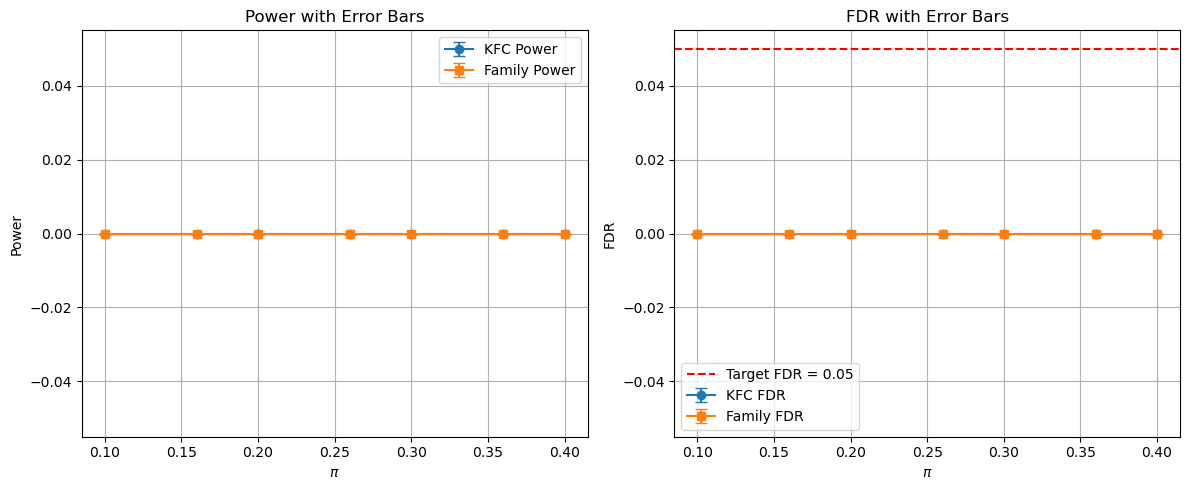

In [72]:
FDR_KFC = []
err_KFC = []

FDR_two_class = []
err_two_class = []

power_KFC = []
err_power_KFC = []

power_two_class = []
err_power_two_class = []

#Main plots
for idx, pi in enumerate(pis):
    output = power_output[idx]
    FDR_KFC.append(np.mean(output['FDP_KFC']))
    FDR_two_class.append(np.mean(output['FDP_family']))
    power_KFC.append(np.mean(output['KFC_power']))
    power_two_class.append(np.mean(output['Family_power']))
    
    err_KFC.append(np.std(output['FDP_KFC']))
    err_two_class.append(np.std(output['FDP_family']))
    err_power_KFC.append(np.std(output['KFC_power']))
    err_power_two_class.append(np.std(output['Family_power']))

# Create two subplots: one for power and one for FDR
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot power with error bars
axes[0].errorbar(pis, power_KFC, yerr=err_power_KFC, fmt='-o', capsize=4, label='KFC Power')
axes[0].errorbar(pis, power_two_class, yerr=err_power_two_class, fmt='-s', capsize=4, label='Family Power')
axes[0].set_xlabel(r'$\pi$')
axes[0].set_ylabel('Power')
axes[0].set_title('Power with Error Bars')
axes[0].legend()
axes[0].grid(True)

# Plot FDR with error bars
axes[1].errorbar(pis, FDR_KFC, yerr=err_KFC, capsize=4, fmt='-o', label='KFC FDR')
axes[1].errorbar(pis, FDR_two_class, yerr=err_two_class, fmt='-s',capsize=4, label='Family FDR')
axes[1].axhline(y=0.05, color='red', linestyle='--', label='Target FDR = 0.05')
axes[1].set_xlabel(r'$\pi$')
axes[1].set_ylabel('FDR')
axes[1].set_title('FDR with Error Bars')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

In [ ]:
model_parameters = [0.1, 0.3, 0.5, 0.7]
model_family = []

for nu in model_parameters:
    model_family.append(OneClassSVM(nu=nu, kernel='rbf', gamma='scale'))

KFC_classifier = OneClassSVM(nu=0.01, kernel='rbf', gamma='scale', degree= 5)  # initialize base model
power_output = []

num_sims = 100
pis = [0.1, 0.16, 0.2, 0.26, 0.3, 0.36, 0.4]
alphas = [0.01, 0.05]

for pi in pis:
    total_output = { 'KFC_power': [], 'Family_power': [], 'FDP_KFC': [], 'FDP_family': []}
    for seed in range(num_sims):
        output = family_procedure(signal_set, null_set, n= 500, m= 50, pi = pi, K_blocks = 10, model_family = model_family, 
                   KFC_classifier = KFC_classifier, seed = seed)
        total_output['KFC_power'].append(output['KFC_power'])
        total_output['Family_power'].append(output['family_power'])
        total_output['FDP_KFC'].append(output['FDP_KFC'])
        total_output['FDP_family'].append(output['FDP_family'])
        print(f'Done sim {seed}/{num_sims}')
    print(np.mean(total_output['Family_power']), np.mean(total_output['KFC_power']))
    print(f'Done with {pi}')
    power_output.append(total_output)

In [32]:
global_file = '/Users/iliapopov/Desktop/e-BH/ebhconformal/signals_and_nulls.npz'

if os.path.exists(global_file):
    loaded = np.load(global_file, allow_pickle=True)
    
    # Retrieve the data (convert back to lists if needed)
    signal_set = loaded['signal_set']
    null_set = loaded['null_set']
    
    #Cleaning up the nulls:
    rows_to_keep = ~np.any(pd.isna(signal_set), axis=1)
    signal_set= signal_set[rows_to_keep]
    
    rows_to_keep = ~np.any(pd.isna(null_set), axis=1)
    null_set = null_set[rows_to_keep]
    
    last_idx = int(loaded['last_idx'])
    
    print(f"Retrieved {len(signal_set)} signals.")
    print(f"Retrieved {len(null_set)} nulls.")
    print(f"Last processed signal index: {last_idx}")
else:
    print("Global file does not exist!")

Retrieved 82 signals.
Retrieved 3728 nulls.
Last processed signal index: 91


In [45]:
model_parameters = [0.1, 0.3, 0.5, 0.7]
pi = 1
seed = 42
model_family = []

for nu in model_parameters:
    model_family.append(OneClassSVM(nu=nu, kernel='rbf', gamma='scale'))

KFC_classifier = OneClassSVM(nu=0.01, kernel='rbf', gamma='scale', degree= 5)  # initialize base model

family_procedure(signal_set, null_set, n= 3000, m= 80, pi = pi, K_blocks = 80, model_family = model_family, 
                   KFC_classifier = KFC_classifier, seed = seed)

{'KFC_power': 0.0, 'family_power': 0.0, 'FDP_KFC': 0.0, 'FDP_family': 0.0}

In [ ]:
def test_procedure(signal_set, null_set, n, m, pi, KFC_classifier,two_class_classifier, alpha_fdr = 0.05,  K_blocks = 20, seed=1):
    adjustment = 1/(1+alpha_fdr)
    
    np.random.seed(seed)
    null_size = int(np.ceil((1-pi) * m + n))
    signal_size = int(np.ceil(pi * m))
    
    perm = np.random.permutation(m)
    nonzero_idx = np.sort(perm[:signal_size])
    null_idx = np.sort(perm[signal_size:])
    
    # Check if provided sets have sufficient rows
    if null_set.shape[0] < null_size or signal_set.shape[0] < signal_size:
        print('Sizes of arrays do not match the setting')
        return None
    else:
        null_rows = np.random.choice(null_set.shape[0], size=null_size, replace=False)
        signal_rows = np.random.choice(signal_set.shape[0], size=signal_size, replace=False)
        
        nulls = null_set[null_rows, :]
        signals = signal_set[signal_rows, :]
        
         # weights are just ones vector
        test_weights = np.ones(m)
        cal_weights = np.ones(n)
        
        Xtest = np.zeros((m, nulls.shape[1]))
        Xtest[nonzero_idx, :] = signals
        
        # Calculate the number of null rows to use for test data.
        num_null_test = int(np.ceil((1-pi) * m))
        Xtest[null_idx, :] = nulls[:num_null_test]
        
        # The remaining null rows are assigned to Xtrain.
        Xref = nulls[num_null_test:]
        
        blocks = np.array_split(np.arange(m), K_blocks)    # split the D_test into K_blocks blocks
        
        # score matrix making subroutine
        real_score_matrix = subroutine(KFC_classifier, Xref, Xtest, blocks)    # original
        two_class_score_matrix = subroutine_with_twoclass(KFC_classifier, two_class_classifier, Xref, Xtest, blocks)
        
        # make full conformal e-values

        e_values_KFC = e_function_static(adjustment*alpha_fdr, real_score_matrix, cal_weights, test_weights)
        e_values_two = e_function_static(adjustment*alpha_fdr, two_class_score_matrix, cal_weights, test_weights)
        
        e_rej = eBH(e_values_KFC, alpha_fdr)
        e_rej_two_class = eBH(e_values_two, alpha_fdr)
        
        output = { 'KFC_power': compute_power(e_rej, nonzero_idx), 'Two_Class_power': compute_power(e_rej_two_class, nonzero_idx), 'FDP_KFC': compute_fdp(e_rej, null_idx), 'FDP_Two_class': compute_fdp(e_rej_two_class, null_idx)}
        return output